<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/DS_Unit_2_Sprint_Challenge_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [0]:
# TODO - your work!


In [0]:
!pip install seaborn==0.9.0 -q
!pip install -U matplotlib

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import optimize
from scipy import stats
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import scale



In [0]:
 sns.__version__

In [0]:
column_names = ['age',
            'workclass',
            'fnlwgt', 
            'education',
            'education-num',
            'marital-status',
            'occupation',
            'relationship',
            'race',
            'sex',
            'capital-gain',
            'capital-loss', 
            'hours-per-week',
            'native-country', 
            'income']

In [105]:
raw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                  header=None, names=column_names)
raw.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [12]:
raw.shape 
#number of instances is lower than in the data specifications, 
#it might be because of other files in the data folder, I'll keep working with this file

(32561, 15)

In [0]:
raw.describe()

In [0]:
raw.isna().sum()

In [0]:
for column in raw.columns:
  print(column, raw[column].unique())
#from the output below, the missing data is entered as '?'  

In [0]:
raw.replace(' ?','unknown', inplace = True)

In [38]:
raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
#check for '? again'
for column in raw.columns:
  print(column, raw[column].unique()) #the space in ' ?' was confusing, now it's solved!

In [0]:
raw.info()

In [0]:
#lets group all school education into one group
raw['education']=np.where(raw['education'] ==' 7th-8th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 9th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 5th-6th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 10th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 1st-4th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 12th', 'Basic', raw['education'])
raw['education']=np.where(raw['education'] ==' 11th', 'Basic', raw['education'])

In [46]:
raw.education.unique()

array([' Bachelors', ' HS-grad', 'Basic', ' Masters', ' Some-college',
       ' Assoc-acdm', ' Assoc-voc', ' Doctorate', ' Prof-school',
       ' Preschool'], dtype=object)

In [0]:
raw.info()

In [0]:
#scale the numeric columns in data:
def scale_num(df):
  for col in df.columns:
      if(df[col].dtype == 'int64'):
          df[col]= scale(df[col])
         
  return df         

raw = scale_num(raw)

In [0]:
#encode the target feature:
raw.income.replace({' <=50K':0, ' >50K':1}, inplace=True)

In [0]:
#hot-encode the categorical features
def encode_cat(df):
  for col in df.columns:
      if(df[col].dtype == 'object'):
          df[col]= df[col].astype('category')
          df[col] = df[col].cat.codes
  return df         

raw = encode_cat(raw)

In [0]:
raw.info()

In [0]:
#take a copy of data
d = raw.copy()

In [0]:
#data is ready!
d.head()

## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [0]:
# TODO - your work!

#define target variable and features
X = d.drop('income', axis=1)
y = d['income']

#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


#fit the logistic regression model
log_reg = LogisticRegression(multi_class='auto',solver='lbfgs', max_iter=500).fit(X_train, y_train);


In [83]:
#print the model metrics:
print("Multinomial Logistic regression Train Accuracy :", metrics.accuracy_score(y_train, log_reg.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy :", metrics.accuracy_score(y_test, log_reg.predict(X_test)))


Multinomial Logistic regression Train Accuracy : 0.8245162776412777
Multinomial Logistic regression Test Accuracy : 0.826654383540611


the coefficient of determination $R^2$ of the prediction on the test data is  0.8245, which tells that the model fits the data fairly well!.

In [85]:
# each estimated coefficient is the expected change in the log odds of being a reference [1] class 
# for a unit increase in the corresponding predictor variable 
# holding the other predictor variables constant at certain value.  

log_reg.coef_

array([[ 4.86977548e-01, -1.21020077e-01,  5.83329390e-02,
         2.27603751e-02,  8.78776951e-01, -2.37063941e-01,
        -2.28383474e-03, -1.12470517e-01,  1.25583956e-01,
         9.46504544e-01,  2.30284727e+00,  2.64743809e-01,
         3.66271312e-01,  2.15729734e-03]])

In [102]:
results = list(zip(X.columns,log_reg.coef_[0]))
key_factors = sorted(results, key=lambda x: x[1], reverse=True)
print('For a unit increase in a predictor variable the expected change in the log' 
      ' odds of gaining income more than 50k is respectively')
for factor in key_factors:
  print('{}  {}'.format(factor[0], factor[1]))
 

For a unit increase in a predictor variable the expected change in the log odds of gaining income more than 50k is respectively
capital-gain  2.302847273929391
sex  0.9465045439099444
education-num  0.8787769512729501
age  0.48697754764470896
hours-per-week  0.3662713124214009
capital-loss  0.264743809376026
race  0.12558395586934396
fnlwgt  0.0583329389958477
education  0.022760375107647984
native-country  0.002157297338280324
occupation  -0.002283834742294827
relationship  -0.11247051667774254
workclass  -0.12102007748548396
marital-status  -0.23706394117115773


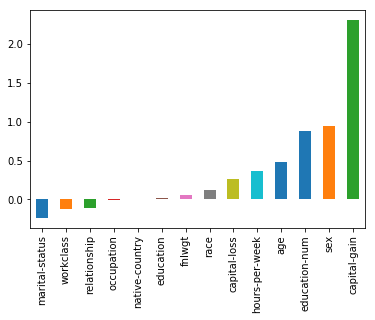

capital-gain      2.302847
sex               0.946505
education-num     0.878777
age               0.486978
hours-per-week    0.366271
capital-loss      0.264744
race              0.125584
fnlwgt            0.058333
education         0.022760
native-country    0.002157
occupation       -0.002284
relationship     -0.112471
workclass        -0.121020
marital-status   -0.237064
dtype: float64


In [137]:
coefs = pd.Series(log_reg.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print(coefs.sort_values(ascending = False))

From the output above, it's clear that the main three factors predicting gaining income more than 50k a year are capital-gain, gender,  and length of education received

In [130]:
X_test.iloc[:1, :]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14160,-0.84908,3,-0.280444,8,-0.03136,0,0,1,4,0,-0.14592,-0.21666,-0.197409,38


In [131]:
#let's see the results on example of a person from the observations,
#output lists of probabilities of being each class for an example
log_reg.predict_proba(X_test.iloc[:1, :]) 

array([[0.90250354, 0.09749646]])

the results above show for the observation number 14160, the likelihood of gaining less than 50k a year are higher, 0.9025

In [132]:
#check the results on the raw data
raw.iloc[14161, :]

age                           38
workclass                Private
fnlwgt                    680390
education                HS-grad
education-num                  9
marital-status          Divorced
occupation          Adm-clerical
relationship           Unmarried
race                       White
sex                       Female
capital-gain                   0
capital-loss                   0
hours-per-week                20
native-country     United-States
income                     <=50K
Name: 14161, dtype: object

the raw data confirmed the results yilded by the model

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

**TODO - your answers!**

1.
From the output above, it's clear that the main three factors predicting gaining income more than 50k a year are:
- capital-gain with a coefficient of 2.30284, 
- gender with a coefficient of 0.9465,  and 
- education-num, length of education received, with a coefficient of 0.8787

2.
Three features negatively correlated with income above 50k are:
- marital-status, with coefficient of -0.23
- workclass, with coefficient of -0.12
- relationship, with coefficient of -0.11

3.
Overall, the model fits data fairly well, with a good predictive power, which tells that a male, who received a lengthy education (which implies higher degree), and has capital gains would more likely have income more than 50k a year. Also, being single, divorsed, in a low-paid workclass (like, priv-house-serv, or Other-service ), raising child being a single parent,  being very young, and having only a preschool education significantly decreases the likelihood of gaining income more than 50k a year.




1. _You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades._
For this situation, I would use a Quantile Regression model, since it can target  students specifically at the bottom tier of grades through a given quantile (0-100%), instead of through the mean values. In this case, a quantile for the bottom tier would be established, like 5%. And then, using Quantile Regression we would find the line of best fit. Meaning, conditional on x, only 10% of true values would be below the predicted value. 
.

2. _You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched._
For this situation, I would use Survival Analyses, since it is a good fit to model anything with a finite duration, here the 'death' event in survival analysis would be launching a new product, and duration is time when it's launched. Survival analysis allows us to fit a model when many of the data points are censored. Like, sometimes we are not able to observe "death" events, we only now information like "...it's been X months since Apple has released the last iphone.". Survival analysis allows us to correct for this censorship in data.

3. _You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time._ The situation of overparametrization indicates that there is no unique solution. In this situation, normal regression would yield overfitting results. Ridge regression would be a good fit for this situation. This bias introduced by ridge regression mitigates overfitting, and allows the model to generalize better from few  observations in data. 

